# 5. CLIP

Contrastive Language-Image Pre-Training or [CLIP](https://github.com/openai/CLIP/tree/main) is a text and image encoding tool used with many popular Generative AI models such as [DALL-E](https://openai.com/dall-e-2) and [Stable Diffusion](https://github.com/Stability-AI/stablediffusion).

CLIP in itself is not a Generative AI model, but is instead used to align text encodings with image encodings. If there is such a thing as the perfect text description of an image, the goal of CLIP is to create the same vector embedding for both the image and the text. Let's see what this means in practice.

The goals of this notebook are to:
* Learn how to use CLIP Encodings
  * Get an image encoding
  * Get a text encoding
  * Calculate the cosine similarity between them
* Use CLIP to create a text-to-image neural network

## 5.1 Encodings

First, let's load the libraries needed for this exercise.

In [1]:
import os
import sys
import random

import csv
import glob
import numpy as np
import torch
import torch.nn.functional as F
from torch.optim import Adam
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Visualization tools
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.utils import save_image, make_grid
from textwrap import wrap

# User defined libraries
from utils import other_utils
from utils import ddpm_utils
from utils import UNet_utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

There are a few different variations of CLIP based on popular image recognition neural networks:

In [2]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

For this notebook, we will be using `ViT-B/32`, which is based on the [Vision Transformer](https://huggingface.co/docs/transformers/main/model_doc/vit) architecture. It has `512` features, which we will later feed into our diffusion model.

In [3]:
#clean the gpu
import gc
gc.collect()
torch.cuda.empty_cache()

clip_model, clip_preprocess = clip.load("ViT-B/32")
clip_model.eval()
CLIP_FEATURES = 512

### 5.1.1 Image Encodings

When we load CLIP, it will also come with a set of image transformations we can use to feed images into the CLIP model:

In [4]:
clip_preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7a79ea3e5760>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

We can find the CLIP embedding by first transforming our image with `clip_preprocess` and converting the result to a tensor. Since the `clip_model` expects a batch of images, we can use [np.stack](https://numpy.org/doc/stable/reference/generated/numpy.stack.html) to turn the processed image into a single element batch.

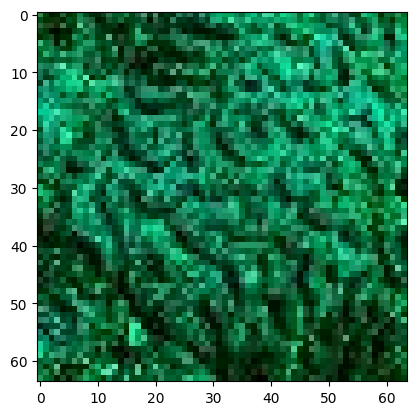

In [5]:
DATA_DIR = "data/tiny-imagenet-200/train/n01917289/images/"
img_path = DATA_DIR + "n01917289_241.JPEG"
img = Image.open(img_path)
plt.imshow(img)

Then, we can pass the batch to `clip_model.encode_image` to find the embedding for the image. Uncomment `clip_img_encoding` if you would like to see what an encoding looks like. When we print the size, it lists `512` features for our `1` image.

In [6]:
clip_imgs = torch.tensor(np.stack([clip_preprocess(img)])).to(device)
clip_imgs.size()
clip_img_encoding = clip_model.encode_image(clip_imgs)
print(clip_img_encoding.size())
#clip_img_encoding

torch.Size([1, 512])


### 5.1.2 Text Encodings

Now that we have an image encoding, let's see if we can get a matching text encoding. Below is a list of different flower descriptions. Like with the images, the text needs to be preprocessed before it can be encoded by CLIP. To do this, CLIP comes with a `tokenize` function in order to convert each word into an integer.

In [7]:
text_list = [
    "A lush green forest",
    "An emotional sunset",
    "A concert in a theater"
]
text_tokens = clip.tokenize(text_list).to(device)

Then, we can pass the tokens to `encode_text` to get our text encodings. Uncomment `clip_text_encodings` if you would like to see what an encoding looks like. Similar to our image encoding, there are `512` features for each of our `3` images.

In [8]:
clip_text_encodings = clip_model.encode_text(text_tokens).float()
print(clip_text_encodings.size())
#clip_text_encodings

torch.Size([3, 512])


### 5.1.3 Similarity

In order to see which one of our text descriptions best describes the daisy, we can calculate the [cosine similarity](https://medium.com/@milana.shxanukova15/cosine-distance-and-cosine-similarity-a5da0e4d9ded) between the text encodings and the image encodings. When the cosine similarity is `1`, it's a perfect match. When the cosine similarity is `-1`, the two encodings are opposites.

The cosine similarity is equivalent to a [dot product](https://mathworld.wolfram.com/DotProduct.html) with each vector normalized by their magnitude. In other words, the magnitude of each vector becomes `1`.

We can use the following formula to calculate the dot product:

$X \cdot Y = \sum_{i=1}^{n} x_i y_i = x_1y_1 + x_2 y_2 + \cdots  + x_n y_n$

In [9]:
clip_img_encoding /= clip_img_encoding.norm(dim=-1, keepdim=True)
clip_text_encodings /= clip_text_encodings.norm(dim=-1, keepdim=True)
similarity = (clip_text_encodings * clip_img_encoding).sum(-1)
similarity

tensor([0.2504, 0.1595, 0.1685], device='cuda:0', grad_fn=<SumBackward1>)

Let's practice a little more. Below, we've added a sunflower and a rose image.

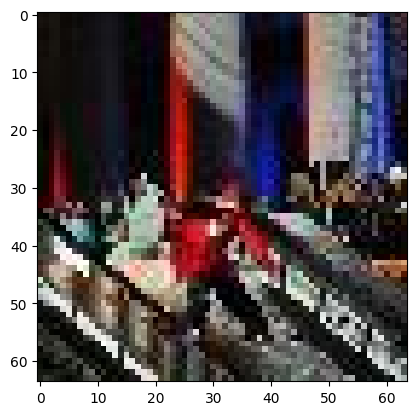

In [10]:
img_paths = [
    "data/tiny-imagenet-200/train/n01917289/images/n01917289_241.JPEG",
    "data/tiny-imagenet-200/train/n09428293/images/n09428293_75.JPEG",
    "data/tiny-imagenet-200/train/n02788148/images/n02788148_11.JPEG",
]

imgs = [Image.open(path) for path in img_paths]
for img in imgs:
    plt.imshow(img)

In [11]:

def get_img_encodings(imgs):
    processed_imgs = [clip_preprocess(img) for img in imgs]
    clip_imgs = torch.tensor(np.stack(processed_imgs)).to(device)
    clip_img_encodings = clip_model.encode_image(clip_imgs)
    return clip_img_encodings

clip_img_encodings = get_img_encodings(imgs)

In [12]:
text_list = [
    "A lush green forest",
    "An emotional sunset",
    "A concert in a theater"
]
text_tokens = clip.tokenize(text_list).to(device)
clip_text_encodings = clip_model.encode_text(text_tokens).float()

It would be nice to compare each combination of text and image. To do so, we can [repeat](https://pytorch.org/docs/stable/generated/torch.Tensor.repeat.html#torch.Tensor.repeat) each text encoding for each image encoding. Similarly, we can [repeat_interleave](https://pytorch.org/docs/stable/generated/torch.repeat_interleave.html) each image encoding for each text encoding.

In [13]:
clip_img_encodings /= clip_img_encodings.norm(dim=-1, keepdim=True)
clip_text_encodings /= clip_text_encodings.norm(dim=-1, keepdim=True)

n_imgs = len(imgs)
n_text = len(text_list)

repeated_clip_text_encodings = clip_text_encodings.repeat(n_imgs, 1)
repeated_clip_img_encoding = clip_img_encodings.repeat_interleave(n_text, dim=0)

similarity = (repeated_clip_text_encodings * repeated_clip_img_encoding).sum(-1)
similarity = torch.unflatten(similarity, 0, (n_text, n_imgs))

Let's compare. Ideally, the diagonal from the top left to the bottom right should be a bright yellow corresponding to their high value. The rest of the values should be low and blue.

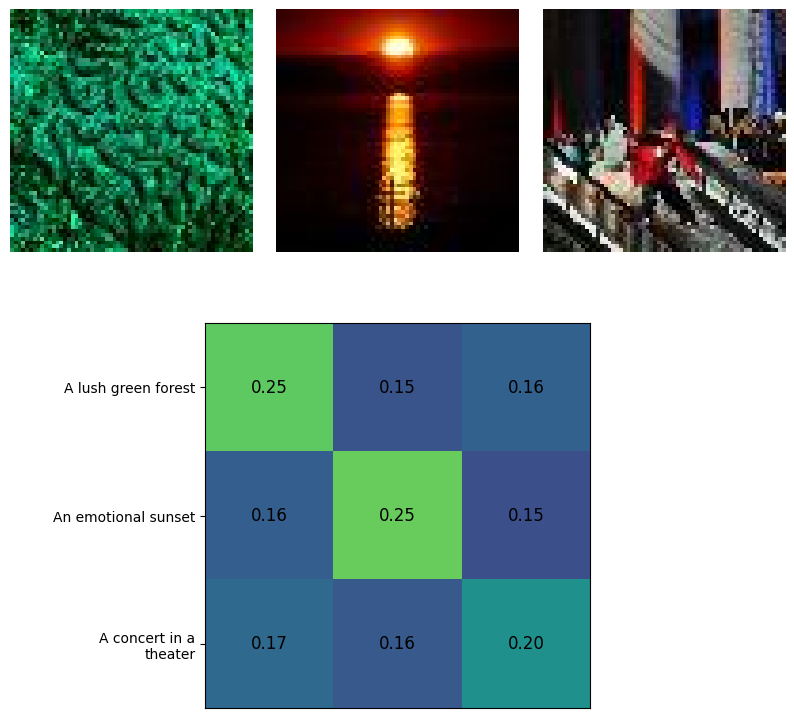

In [14]:
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(2, 3, wspace=.1, hspace=0)

for i, img in enumerate(imgs):
    ax = fig.add_subplot(gs[0, i])
    ax.axis("off")
    plt.imshow(img)

ax = fig.add_subplot(gs[1, :])
plt.imshow(similarity.detach().cpu().numpy().T, vmin=0.1, vmax=0.3)

labels = [ '\n'.join(wrap(text, 20)) for text in text_list ]
plt.yticks(range(n_text), labels, fontsize=10)
plt.xticks([])

for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[x, y]:.2f}", ha="center", va="center", size=12)

## 5.2 A CLIP Dataset

Here, we're going to use CLIP encodings as our label.

If the goal of CLIP is to align text encodings with image encodings, do we need a text description for each of the images in our dataset? Hypothesis: we do not need text descriptions and only need the image CLIP encodings to create a text-to-image pipeline.

To test this out, let's add the CLIP encodings as the "label" to our dataset. Running CLIP on each batch of data augmented images would be more accurate, but it is also slower. We can speed things up by preprocessing and storing the encodings ahead of time.


In [15]:
# Point this to your extracted dataset root
dataset_root = "data/tiny-imagenet-200"

# Collect all image files (train + val; skip test if no labels needed)
train_paths = glob.glob(f"{dataset_root}/train/*/images/*.JPEG")
val_paths = glob.glob(f"{dataset_root}/val/images/*.JPEG")

# Combine them ?
data_paths = train_paths # + val_paths

ndata = 10000
print(f"Found {len(data_paths)} total images, but using only {ndata}")

# To save time, I only use a subset of the (shuffled) data
random.seed(11)
# Add a flag to prevent re-shuffling
if 'data_paths_shuffled' not in globals():
    print("Shuffling data for the first time...")
    random.shuffle(data_paths)
    data_paths = data_paths[:ndata]
    data_paths_shuffled = True
else:
    print("Data already shuffled, using existing order")
print(data_paths[:5])  # sanity check

Found 100000 total images, but using only 10000
Shuffling data for the first time...
['data/tiny-imagenet-200/train/n04560804/images/n04560804_489.JPEG', 'data/tiny-imagenet-200/train/n04376876/images/n04376876_163.JPEG', 'data/tiny-imagenet-200/train/n04067472/images/n04067472_43.JPEG', 'data/tiny-imagenet-200/train/n03584254/images/n03584254_29.JPEG', 'data/tiny-imagenet-200/train/n04251144/images/n04251144_309.JPEG']


The next code block runs the following loop for each filepath:
* Open the image associated with the path and store it in `img`
* Preprocess the image, find the CLIP encoding, and store it in `clip_img`
* Convert the CLIP encoding from a tensor to a python list
* Store the filepath and the CLIP encoding as a row in a csv file

In [16]:
csv_path = 'clip.csv'

# Version that skips already processed images
import time
import os

batch_size = 64   # Larger batch size for better GPU utilization

# Check if CSV exists and load existing paths
existing_paths = set()
if os.path.exists(csv_path):
    print(f"Found existing CSV file: {csv_path}")
    with open(csv_path, 'r', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            if row:  # Skip empty rows
                existing_paths.add(row[0])
    print(f"Found {len(existing_paths)} already processed images")
else:
    print(f"Creating new CSV file: {csv_path}")

# Filter out already processed paths
remaining_paths = [path for path in data_paths if path not in existing_paths]
print(f"Processing {len(remaining_paths)} new images (skipping {len(existing_paths)} already done)")

if len(remaining_paths) == 0:
    print("All images already processed!")
else:
    all_rows = []
    start_time = time.time()

    for batch_start in range(0, len(remaining_paths), batch_size):
        batch_end = min(batch_start + batch_size, len(remaining_paths))
        batch_paths = remaining_paths[batch_start:batch_end]
        
        # Load and preprocess batch of images (sequential, no additional preprocessing)
        batch_imgs = []
        valid_paths = []
        
        # First prepocess all images in the batch
        for path in batch_paths:
            try:
                img = Image.open(path).convert('RGB')
                # Use CLIP's standard preprocessing without additional resizing
                processed_img = clip_preprocess(img)
                batch_imgs.append(processed_img)
                valid_paths.append(path)
            except Exception as e:
                print(f"Error processing {path}: {e}")
                continue
        
        # Then encode them in a single forward pass
        if batch_imgs:
            # Process entire batch at once
            clip_imgs_batch = torch.stack(batch_imgs).to(device)
            
            with torch.no_grad():  # Save memory during inference
                labels_batch = clip_model.encode_image(clip_imgs_batch)
            
            # Convert to lists and store
            for path, label in zip(valid_paths, labels_batch):
                all_rows.append([path] + label.cpu().tolist())
            
            # Clear GPU memory periodically
            if (batch_start // batch_size + 1) % 20 == 0:
                torch.cuda.empty_cache()
        
        # Progress update with timing
        if (batch_start // batch_size + 1) % 10 == 0:
            elapsed = time.time() - start_time
            rate = batch_end / elapsed
            remaining = (len(remaining_paths) - batch_end) / rate if rate > 0 else 0
            print(f"Processed {batch_end}/{len(remaining_paths)} new images... "
                  f"Rate: {rate:.1f} imgs/sec, ETA: {remaining:.0f}s")

    # Append new rows to existing CSV file
    if all_rows:
        print(f"Appending {len(all_rows)} new entries to CSV...")
        with open(csv_path, 'a', newline='') as csvfile:
            writer = csv.writer(csvfile, delimiter=',')
            writer.writerows(all_rows)
        
        total_time = time.time() - start_time
        print(f"Completed! Processed {len(all_rows)} new images in {total_time:.1f}s")
        print(f"Average rate: {len(all_rows)/total_time:.1f} images/second")
    
    print(f"Total images in dataset: {len(existing_paths) + len(all_rows)}")
    print(f"CSV saved to: {csv_path}")

Found existing CSV file: clip.csv
Found 10000 already processed images
Processing 0 new images (skipping 10000 already done)
All images already processed!


In order to store the images on the GPU, we will have a list of `pre_transforms` that will run one time when we initialize our dataset. Then, the `random_transforms` will run on each batch when it is pulled from the dataset.

[Resize](https://pytorch.org/vision/stable/generated/torchvision.transforms.Resize.html) will resize an image so that the smaller edge between the width and height matches the size we specify. Then, we can use [RandomCrop](https://pytorch.org/vision/main/generated/torchvision.transforms.RandomCrop.html) to both make the image square and effectively increase the size of our dataset with random data augmentation.

In [17]:
IMG_CH = 3
IMG_SIZE = 32
BATCH_SIZE = 16
INPUT_SIZE = (IMG_CH, IMG_SIZE, IMG_SIZE)

pre_transforms = [
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),  # Scales data into [0,1]
    transforms.Lambda(lambda t: (t * 2) - 1)  # Scale between [-1, 1]
]
pre_transforms = transforms.Compose(pre_transforms)
random_transforms = [
    transforms.RandomCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
]
random_transforms = transforms.Compose(random_transforms)

Below is the code to initialize our new dataset. Since we've `preprocessed_clip`, we will preload it onto our GPU with the `__init__` function. We've kept the "on the fly" CLIP encoding as an option. It will produce slightly better results, but it is much slower.

In [18]:
class MyDataset(Dataset):
    def __init__(self, csv_path, preprocessed_clip=True):
        self.imgs = []
        self.preprocessed_clip = preprocessed_clip
        if preprocessed_clip:
            self.labels = torch.empty(
                len(data_paths), CLIP_FEATURES, dtype=torch.float, device=device
            )
        
        with open(csv_path, newline='') as csvfile:
            reader = csv.reader(csvfile, delimiter=',')
            for idx, row in enumerate(reader):
                img = Image.open(row[0]).convert('RGB')  # Ensures all images are 3-channel RGB
                self.imgs.append(pre_transforms(img).to(device))
                if preprocessed_clip:
                    label = [float(x) for x in row[1:]]
                    self.labels[idx, :] = torch.FloatTensor(label).to(device)

    def __getitem__(self, idx):
        img = random_transforms(self.imgs[idx])
        if self.preprocessed_clip:
            label = self.labels[idx]
        else:
            batch_img = img[None, :, :, :]
            encoded_imgs = clip_model.encode_image(clip_preprocess(batch_img))
            label = encoded_imgs.to(device).float()[0]
        return img, label

    def __len__(self):
        return len(self.imgs)

In [19]:
train_data = MyDataset(csv_path, preprocessed_clip=True)
dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

To learn the noise, we use a `UNet` architecture. 
The main structure is described in the [UNet_utils.py](utils/UNet_utils.py) folder, but here we highlight some important features.

The `__init__` function contains `c_embed_dim`. Like for timestep `t`, we create an embedding for our class categories that for our choice of using CLIP, it has the goal of storing the `CLIP_FEATURES`

```python
        self.sinusoidaltime = SinusoidalPositionEmbedBlock(t_embed_dim)
        self.t_emb1 = EmbedBlock(t_embed_dim, up_chs[0])
        self.t_emb2 = EmbedBlock(t_embed_dim, up_chs[1])
        self.c_embed1 = EmbedBlock(c_embed_dim, up_chs[0]) 
        self.c_embed2 = EmbedBlock(c_embed_dim, up_chs[1]) 
```

Next, in the `forward` function, we have two important parameters: `c` and `c_mask`.
* `c` is a vector representing our categorical input. It can be a [one-hot encoding](https://www.kaggle.com/code/dansbecker/using-categorical-data-with-one-hot-encoding) or an embedding vector, but in our case it will be the *CLIP context*.
* `c_mask` is used to randomly set values within `c` to zero. This helps the model learn what an average output might be without context driving.

```python
        c = c * c_mask
        c_emb1 = self.c_embed1(c)
        c_emb2 = self.c_embed2(c)
```

There are many different ways we can combine this embedded categorical information into the model. One popular method is with [scaling and shifting](https://arxiv.org/pdf/2210.08823.pdf). We can scale (multiply) our categorical embedding to the latent image and then (add) our time embedding `t_emb`. The scale and shift act as a sort of variance and average respectively.

```python
        up0 = self.up0(latent_vec)
        up1 = self.up1(c_emb1 * up0 + t_emb1, down2)  # Changed
        up2 = self.up2(c_emb2 * up1 + t_emb2, down1)  # Changed
        return self.out(torch.cat((up2, down0), 1))
```


In [20]:
T = 400
B_start = 0.0001
B_end = 0.02
B = torch.linspace(B_start, B_end, T).to(device)

ddpm = ddpm_utils.DDPM(B, device)
model = UNet_utils.UNet(
    T, IMG_CH, IMG_SIZE, down_chs=(256, 256, 512), t_embed_dim=8, c_embed_dim=CLIP_FEATURES
)
print("Num params: ", sum(p.numel() for p in model.parameters()))
model_tinyimg = torch.compile(model.to(device))

Num params:  44900355


Let's also recreate the `sample_*` function. It will take our `text_list` as a parameter and convert it to a CLIP encoding. The `sample_w` function is discussed in the [ddpm_utils.py](utils/ddpm_utils.py).

In [21]:
def sample_tinyimg(text_list):
    text_tokens = clip.tokenize(text_list).to(device)
    c = clip_model.encode_text(text_tokens).float()
    x_gen, x_gen_store = ddpm_utils.sample_w(model, ddpm, INPUT_SIZE, T, c, device)
    return x_gen, x_gen_store

### Training

In [ ]:
epochs=10
c_drop_prob = 0.1
lrate = 1e-4
save_dir = "images/"
checkpoint_path = "model_checkpoint"
# make the directory
os.makedirs(checkpoint_path, exist_ok=True)

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=lrate)

# Load checkpoint if exists
start_epoch = 0
if os.path.exists(checkpoint_path):
    checkpoint_files = [f for f in os.listdir(checkpoint_path) if f.endswith('.pth')]
    if checkpoint_files:
        latest_epoch = max([int(f.split('.')[0]) for f in checkpoint_files])
        latest_checkpoint = os.path.join(checkpoint_path, f"{latest_epoch}.pth")
        checkpoint = torch.load(latest_checkpoint, map_location=device)
        model.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        start_epoch = checkpoint['epoch'] + 1
        print(f"Resumed from epoch {start_epoch}")
else:
    print("Initializing model")

if start_epoch >= epochs:
    print(f"Already trained to epoch {epochs}")
else:
    model.train()
    for epoch in range(start_epoch, epochs):
        # Clean the gpu
        gc.collect()
        torch.cuda.empty_cache()

        for step, batch in enumerate(dataloader):
            optimizer.zero_grad()
            t = torch.randint(0, T, (BATCH_SIZE,), device=device).float()
            x, c = batch
            c_mask = ddpm.get_context_mask(c, c_drop_prob)
            loss = ddpm.get_loss(model_tinyimg, x, t, c, c_mask)
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch} | Step {step:03d} | Loss: {loss.item()}")
        if epoch % 5 == 0 or epoch == int(epochs - 1):
            # Save checkpoint
            torch.save({'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch}, f"{checkpoint_path}/{epoch}.pth")
            x_gen, x_gen_store = sample_tinyimg(text_list)
            grid = make_grid(x_gen.cpu(), nrow=len(text_list))
            save_image(grid, save_dir + f"image_ep{epoch:02}.png")
            print("saved images in " + save_dir + f" for episode {epoch}")

Resumed from epoch 10
Already trained to epoch 10


Showing timesteps: [0, 57, 114, 171, 228, 285, 342, 399]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.7913747..3.448325].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.241431..3.878542].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.7547383..3.7157645].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.0733898..3.5836854].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.505948..3.58628].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.4063044..3.28509].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9743068..3.579

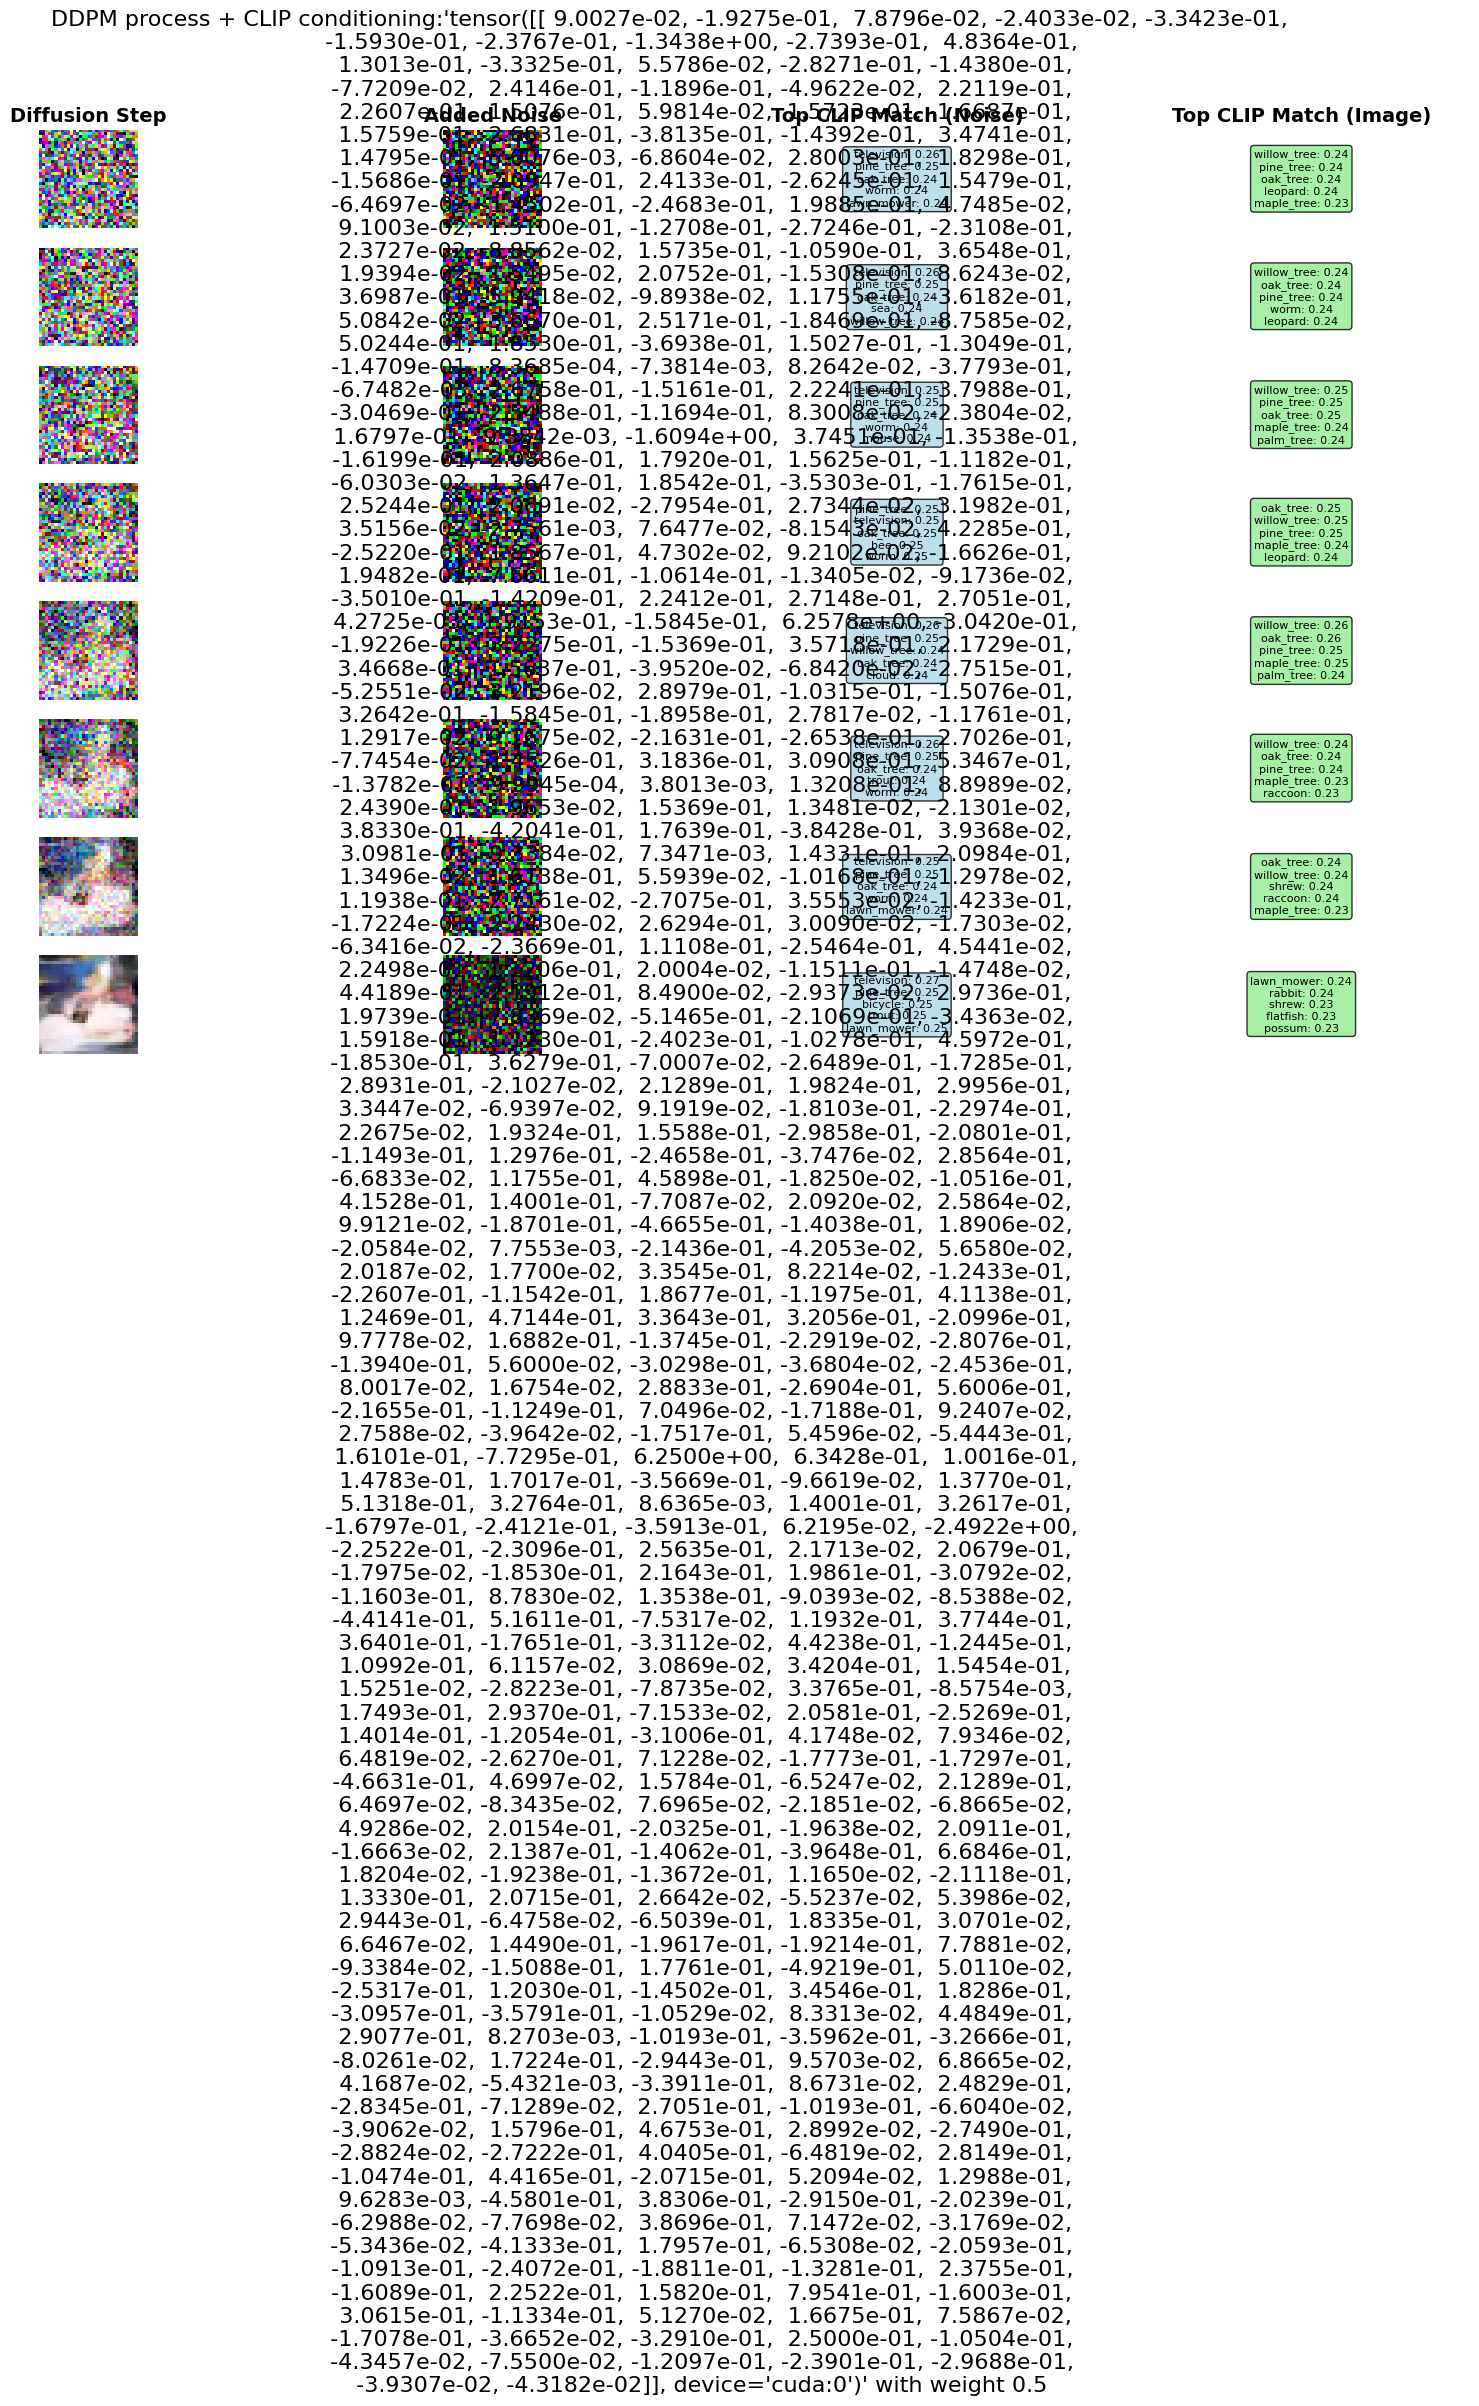

([tensor([[[-1.4437e+00,  2.2849e-01, -8.3387e-01,  ...,  9.7181e-02,
             6.6224e-01,  1.3886e+00],
           [-7.3605e-01, -4.3469e-01,  1.5049e+00,  ...,  2.1797e-01,
            -3.1148e-01,  4.3719e-01],
           [ 8.2970e-01, -7.0661e-02,  8.3187e-01,  ...,  2.3736e-01,
             8.7522e-01, -1.2777e-01],
           ...,
           [ 5.6638e-01, -1.2064e+00, -1.1499e+00,  ..., -2.4098e-01,
            -1.6062e-01, -1.9378e-02],
           [ 3.4501e-01, -1.5170e+00, -2.1044e+00,  ..., -9.4971e-03,
             5.7219e-01, -1.7734e-01],
           [-1.5416e+00, -3.0139e-01, -7.0148e-01,  ..., -1.7452e-01,
            -1.0024e+00, -4.9436e-01]],
  
          [[-4.7805e-01, -1.3261e+00,  9.7695e-01,  ...,  1.3190e+00,
             6.3872e-01,  4.5010e-01],
           [-1.8353e+00, -1.3788e+00,  6.3260e-03,  ..., -2.9314e-01,
            -1.3680e+00,  6.0072e-01],
           [ 1.1776e+00, -1.0931e-01, -6.2277e-01,  ...,  7.4045e-01,
             7.0863e-02,  5.0121e-01],

In [24]:
# Test the diffusion visualization function
ddpm_utils.visualize_diffusion_process(
    ddpm=ddpm,
    model=model,
    clip_model=clip_model,
    clip_preprocess=clip_preprocess,
    embed_size=CLIP_FEATURES,
    device=device,
    img_ch=IMG_CH,
    img_size=IMG_SIZE,
    timesteps_to_show=None,
    prompt= "A big fish",
    w = 0.5,
    top_k = 5,
)

Here you can test different prompts:

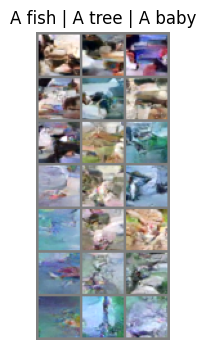

In [25]:
# Change me
text_list = [
    "A fish",
    "A tree",
    "A baby"
]

model.eval()
x_gen, x_gen_store = sample_tinyimg(text_list)
grid = make_grid(x_gen.cpu(), nrow=len(text_list))
other_utils.show_tensor_image([grid], text_list)
plt.show()

Once you've found a set of images you enjoy, run the below cell to turn it into an animation. It will be saved to [05_images/flowers.gif](05_images/flowers.gif)

In [ ]:
#grids = [other_utils.to_image(make_grid(x_gen.cpu(), nrow=len(text_list))) for x_gen in x_gen_store]
#other_utils.save_animation(grids, "images/flowers.gif")

<center><a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a></center>